In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from data.utils.similarity_search import SimilaritySearch
from conf_ensemble import ConfEnsembleLibrary
from rankers.tfd_ranker_sim import TFD2SimRefMCSRanker
from data.utils.enzyme_connector import ENZYMEConnector
from data.utils.pdbbind import PDBbindMetadataProcessor
from data.utils.chembl_connector import ChEMBLConnector
from collections import defaultdict
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.TorsionFingerprints import GetTFDMatrix
from rdkit.Chem.rdchem import Mol, EditableMol

/home/bb596/anaconda3/envs/bioconfpred/lib/python3.7/site-packages/tqdm/auto/__init__.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.std.*` instead of `tqdm._tqdm.*`
  from .._tqdm import TqdmExperimentalWarning
/home/bb596/anaconda3/envs/bioconfpred/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from .._tqdm_notebook import tqdm_notebook as tqdm
/home/bb596/anaconda3/envs/bioconfpred/lib/python3.7/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):
/home/bb596/anaconda3/envs/bioconfpred/lib/python3.7/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version clas

In [2]:
figures_dir = '../hdd/pdbbind_bioactive/figures/'

In [3]:
root = '../hdd/pdbbind_bioactive/data'


cel_df = pd.read_csv(os.path.join(root, 'pdb_conf_ensembles', 'ensemble_names.csv'))
pdb_df = pd.read_csv(os.path.join(root, 'pdb_conf_ensembles', 'pdb_df.csv'))
pdb_df = pdb_df.merge(cel_df, left_on='ligand_name', right_on='ensemble_name')
pdbbind_df = PDBbindMetadataProcessor().get_master_dataframe()
pdbbind_df = pdbbind_df.merge(pdb_df, left_on='PDB code', right_on='pdb_id')

In [34]:
len(pdbbind_df['PDB code'].unique())

13460

In [5]:
cc = ChEMBLConnector()
chembl_table = cc.get_target_table(level=1)
pdbbind_df = pdbbind_df.merge(chembl_table, left_on='Uniprot ID', right_on='accession')

In [8]:
len(pdbbind_df['PDB code'].unique())

9428

In [9]:
9428 / 13460

0.700445765230312

In [6]:
pdbbind_df['level1'].value_counts()

enzyme                         7322
epigenetic regulator            814
transcription factor            466
cytosolic other                 366
unclassified                    325
ion channel                     175
membrane receptor               122
secreted                        116
nuclear other                    76
auxiliary transport protein      52
transporter                      28
membrane other                   13
surface antigen                  13
adhesion                         11
structural                        3
Name: level1, dtype: int64

In [7]:
7322/9428

0.7766228256257955

In [4]:
ec = ENZYMEConnector()
enzyme_table = ec.get_table()
pdbbind_df = pdbbind_df.merge(enzyme_table, left_on='Uniprot ID', right_on='uniprot_id')

Loading enzyme classes data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163761/163761 [00:00<00:00, 803514.43it/s]


In [5]:
len(pdbbind_df['PDB code'].unique())

8800

In [6]:
cel = ConfEnsembleLibrary()

Loading conf ensembles


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10481/10481 [00:16<00:00, 634.62it/s]


In [7]:
ss = SimilaritySearch(cel_df['smiles'].values)

Similarity matrix ready


In [8]:
def get_editable_mol_match(mol, match):
    edit_mol = EditableMol(mol)
    idx_to_remove = []
    for a in mol.GetAtoms():
        atom_idx = a.GetIdx()
        if not atom_idx in match:
            idx_to_remove.append(atom_idx)
    for idx in reversed(idx_to_remove):
        edit_mol.RemoveAtom(idx)
    return edit_mol

def get_full_matrix_from_tril(tril_matrix, n):
    matrix = np.zeros((n, n))
    i=1
    j=0
    for v in tril_matrix:
        matrix[i, j] = matrix[j, i] = v
        j = j + 1
        if j == i:
            i = i + 1
            j = 0
    return matrix

In [18]:
min_tfds = {}
original_ec = defaultdict(list)
closest_ec = defaultdict(list)
mcs_sizes = {}
for ligand_name, ce in tqdm(cel.library.items()):
    try:
        mol = ce.mol
        smiles = Chem.MolToSmiles(mol)

        closest_smiles_list, sim = ss.find_closest_in_set(smiles)
        closest_smiles = closest_smiles_list[0]
        closest_name = cel_df[cel_df['smiles'] == closest_smiles]['ensemble_name'].values[0]
        closest_ce = cel.library[closest_name]
        closest_mol = closest_ce.mol

        ref_mol = closest_mol

        mcs = FindMCS([ref_mol, mol], 
                      timeout=5, 
                      matchChiralTag=True,)
                    #   ringMatchesRingOnly=True)
        smarts = mcs.smartsString
        mcs_mol = Chem.MolFromSmarts(smarts)

        ref_mol_match = ref_mol.GetSubstructMatch(mcs_mol)
        pdb_edit_mol = get_editable_mol_match(ref_mol, ref_mol_match)
        new_ref_mol = pdb_edit_mol.GetMol()
        new_pdb_match = new_ref_mol.GetSubstructMatch(mcs_mol)
        new_ref_mol = Chem.RenumberAtoms(new_ref_mol, new_pdb_match)

        mol_match = mol.GetSubstructMatch(mcs_mol)
        gen_edit_mol = get_editable_mol_match(mol, mol_match)
        new_mol = gen_edit_mol.GetMol()
        new_gen_match = new_mol.GetSubstructMatch(mcs_mol)
        new_mol = Chem.RenumberAtoms(new_mol, new_gen_match)

        bio_conf_idx = []
        for conf in new_ref_mol.GetConformers():
            conf_id = mcs_mol.AddConformer(conf, assignId=True)
            bio_conf_idx.append(conf_id)

        gen_conf_idx = []
        for conf in new_mol.GetConformers():
            conf_id = mcs_mol.AddConformer(conf, assignId=True)
            gen_conf_idx.append(conf_id)
    
        Chem.SanitizeMol(mcs_mol)
        tfd_matrix = GetTFDMatrix(mcs_mol)
        tfd_matrix = get_full_matrix_from_tril(tfd_matrix, 
                                                n=mcs_mol.GetNumConformers())

        n_ref_confs = len(bio_conf_idx)
        tfds = tfd_matrix[:n_ref_confs, n_ref_confs:]
        min_tfd = tfds.min(0)

        if len(min_tfd) == mol.GetNumConformers() :
            mcs_sizes[ligand_name] = mcs_mol.GetNumHeavyAtoms()
            min_tfds[ligand_name] = min_tfd.min()

            subset_pdbbind_df = pdbbind_df[pdbbind_df['smiles'] == smiles]
            ecs = subset_pdbbind_df['level_4'].values
            for ec in ecs:
                original_ec[ligand_name].append(ec)

            subset_pdbbind_df = pdbbind_df[pdbbind_df['smiles'] == closest_smiles]
            ecs = subset_pdbbind_df['level_4'].values
            for ec in ecs:
                closest_ec[ligand_name].append(ec)
    except:
        pass

 14%|████████████████▎                                                                                                  | 1484/10481 [03:42<28:24,  5.28it/s][14:48:05] 

****
Invariant Violation
could not find probe element
Violation occurred on line 71 in file /project/build/temp.linux-x86_64-cpython-37/rdkit/Code/RDGeneral/utils.h
Failed Expression: foundIt
****

 25%|████████████████████████████▉                                                                                      | 2640/10481 [06:44<07:51, 16.61it/s][14:51:07] Explicit valence for atom # 14 N, 4, is greater than permitted
[14:51:09] Explicit valence for atom # 21 N, 4, is greater than permitted
 26%|██████████████████████████████▎                                                                                    | 2757/10481 [07:05<15:25,  8.34it/s][14:51:28] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:51:28] Explicit valence for atom # 12 N, 4, is greater than permitted
 36%|██████████████████

In [19]:
equals = []
not_in_closest = []
no_closest = []
for ligand_name, ecs1 in original_ec.items():
    
    closest_is_original = False
    if ligand_name in closest_ec:
        
        ecs2 = closest_ec[ligand_name]
        for ec1 in ecs1:
            if ec1 in ecs2:
                closest_is_original = True
                break
                
        if closest_is_original:
            equals.append(ligand_name)
        else:
            not_in_closest.append(ligand_name)
            
    else:
        no_closest.append(ligand_name)

In [20]:
len(equals)

4494

In [21]:
len(not_in_closest)

1503

In [43]:
4494 / (4494 + 1503)

0.7493746873436719

In [22]:
len(no_closest)

740

In [35]:
rows = []
for ligand_name, tfd in min_tfds.items():
    row = {}
    row['Ligand name'] = ligand_name
    row['TFD'] = tfd
    ec = None
    if ligand_name in equals:
        ec = 'Same as closest reference molecule'
    if ligand_name in not_in_closest:
        ec = 'Different to closest reference molecule'
    row['Enzyme class'] = ec
    row['MCS size'] = mcs_sizes[ligand_name]
    rows.append(row)

In [36]:
df = pd.DataFrame(rows)

In [46]:
def custom_agg(series) :
    result = ''
    
    mean = series.mean().round(2)
    if not np.isnan(mean) :
        result = result + str(mean)
        
    std = series.std().round(2)
    if not np.isnan(std) :
        result = result + ' ± ' + str(std)
    
    if result == '' :
        result = 'NA'
    return result

In [47]:
df.groupby('Enzyme class').agg(custom_agg)

,TFD,MCS size
Enzyme class,,
Different to closest reference molecule,0.2 ± 0.21,15.7 ± 6.89
Same as closest reference molecule,0.1 ± 0.13,23.41 ± 7.95


In [48]:
df.groupby('Enzyme class').median()

,TFD,MCS size
Enzyme class,,
Different to closest reference molecule,0.124917,14
Same as closest reference molecule,0.048632,23


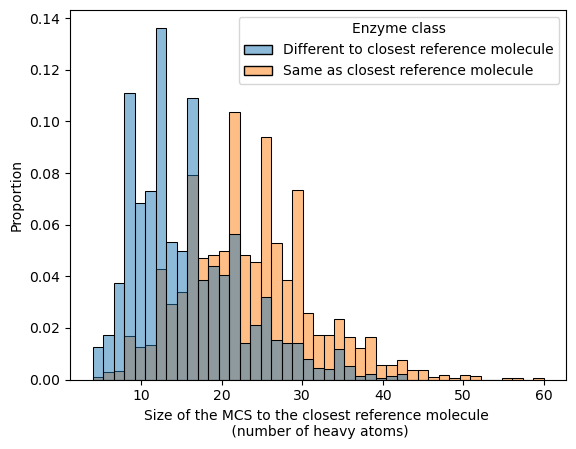

In [41]:
sns.histplot(data=df,
            x='MCS size',
            hue='Enzyme class',
            stat='proportion',
            common_norm=False)
plt.xlabel('Size of the MCS to the closest reference molecule \n (number of heavy atoms)')
plt.savefig(os.path.join(figures_dir, 'TFD_MCS_distribution_hist.png'),
           dpi=300,
           bbox_inches='tight')

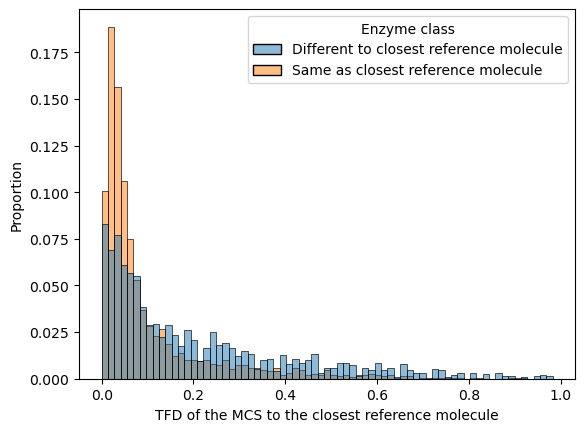

In [42]:
sns.histplot(data=df,
            x='TFD',
            hue='Enzyme class',
            stat='proportion',
            common_norm=False)
plt.xlabel('TFD of the MCS to the closest reference molecule')
plt.savefig(os.path.join(figures_dir, 'TFD_EC_distribution_hist.png'),
           dpi=300,
           bbox_inches='tight')

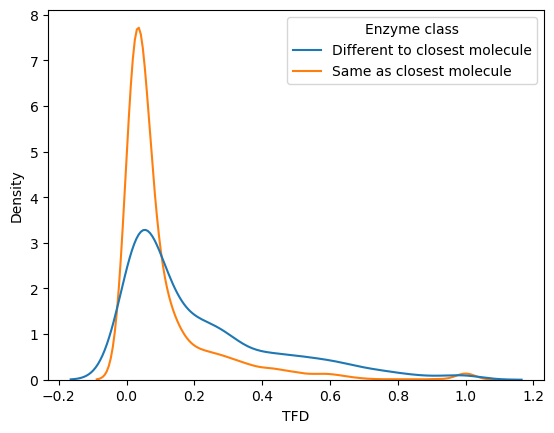

In [25]:
sns.kdeplot(data=df,
            x='TFD',
            hue='Enzyme class',
           common_norm=False)
plt.savefig(os.path.join(figures_dir, 'TFD_EC_distribution_hist.png'),
           dpi=300,
           bbox_inches='tight')

In [50]:
mt = [tfd for ligand_name, tfd in min_tfds.items()]

<AxesSubplot:ylabel='Proportion'>

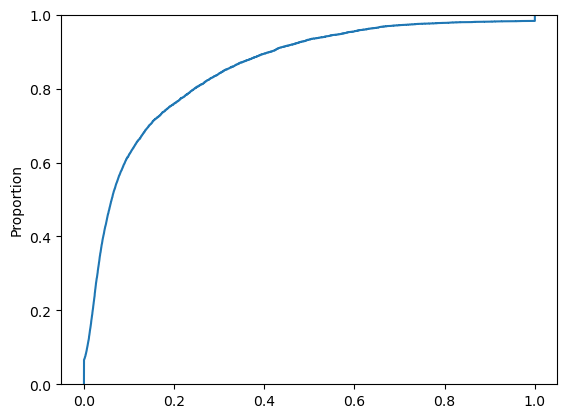

In [51]:
sns.ecdfplot(data=mt)

In [ ]:
plt.hist(mt)